In [1]:
import imageio
import numpy as np
from pathlib import Path
from omegaconf import OmegaConf
import os
from IPython.display import display, Image
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn import linear_model
import torch.nn.functional as F
import torch
import yaml
import lpips
import collections
import scipy.signal

def disp_im(im):
    plt.close()
    plt.cla()
    fig = plt.imshow(im.copy())
    plt.close()
    display(fig.figure)

def merge_dicts(*dicts):
    res = dict()
    for d in dicts:
        for k, v in d.items():
            res[k] = v
    return res

In [2]:
def rgb_ssim(img0, img1, max_val,
             filter_size=11,
             filter_sigma=1.5,
             k1=0.01,
             k2=0.03,
             return_map=False):
    # Modified from https://github.com/google/mipnerf/blob/16e73dfdb52044dcceb47cda5243a686391a6e0f/internal/math.py#L58
    assert len(img0.shape) == 3
    assert img0.shape[-1] == 3
    assert img0.shape == img1.shape

    # Construct a 1D Gaussian blur filter.
    hw = filter_size // 2
    shift = (2 * hw - filter_size + 1) / 2
    f_i = ((np.arange(filter_size) - hw + shift) / filter_sigma)**2
    filt = np.exp(-0.5 * f_i)
    filt /= np.sum(filt)

    # Blur in x and y (faster than the 2D convolution).
    def convolve2d(z, f):
        return scipy.signal.convolve2d(z, f, mode='valid')

    filt_fn = lambda z: np.stack([
        convolve2d(convolve2d(z[...,i], filt[:, None]), filt[None, :])
        for i in range(z.shape[-1])], -1)
    mu0 = filt_fn(img0)
    mu1 = filt_fn(img1)
    mu00 = mu0 * mu0
    mu11 = mu1 * mu1
    mu01 = mu0 * mu1
    sigma00 = filt_fn(img0**2) - mu00
    sigma11 = filt_fn(img1**2) - mu11
    sigma01 = filt_fn(img0 * img1) - mu01

    # Clip the variances and covariances to valid values.
    # Variance must be non-negative:
    sigma00 = np.maximum(0., sigma00)
    sigma11 = np.maximum(0., sigma11)
    sigma01 = np.sign(sigma01) * np.minimum(
        np.sqrt(sigma00 * sigma11), np.abs(sigma01))
    c1 = (k1 * max_val)**2
    c2 = (k2 * max_val)**2
    numer = (2 * mu01 + c1) * (2 * sigma01 + c2)
    denom = (mu00 + mu11 + c1) * (sigma00 + sigma11 + c2)
    ssim_map = numer / denom
    ssim = np.mean(ssim_map)
    return ssim_map if return_map else ssim

device = torch.device('cuda')
loss_fn_alex = lpips.LPIPS(net='alex').to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/dronelab/miniconda3/envs/31/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dronelab/miniconda3/envs/31/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/dronelab/miniconda3/envs/31/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


In [3]:
def fit_bg_color(pred_bg, gt_bg, f, f_inv, reject_outliers=True):
    fH = pred_bg.shape[0]
    sin_vals = np.sin(np.arange(fH) / fH * np.pi).reshape(-1, 1, 1)
    X = f((pred_bg)[:fH//2].reshape(-1, 3))
    Y = f((gt_bg)[:fH//2].reshape(-1, 3))
    # X = f((pred_bg).reshape(-1, 3))
    # Y = f((gt_bg).reshape(-1, 3))

    if reject_outliers:
        bY = np.mean(Y, axis=1)
        S = np.std(bY)*3
        outlier = (bY < np.mean(bY) - S) | (bY > np.mean(bY) + S)
        X = X[~outlier].clip(0, 1e9)
        Y = Y[~outlier]
    fullX = f((pred_bg).reshape(-1, 3))
    fullX = fullX.clip(0, 1e9)
    

    B = np.mean(Y - X, axis=0, keepdims=True)

    M = (np.mean((X) * Y, axis=0) / np.mean((X)**2, axis=0)).reshape(1, 3)

    fit_bg = np.zeros_like(fullX)
    for ci in range(3):
        model = linear_model.LinearRegression()
        model.fit(X[:, ci:ci+1], Y[:, ci:ci+1])
        fit_bg[:, ci:ci+1] = model.predict(fullX[:, ci:ci+1])
        # model = linear_model.HuberRegressor()
        # model.fit(X[:, ci:ci+1], Y[:, ci])
        # fit_bg[:, ci] = model.predict(fullX[:, ci:ci+1])
        
    # print('post_reg', fit_bg.mean(axis=0), Y.mean(axis=0))
    if reject_outliers:
        fit_bg = (M*fullX).reshape(pred_bg.shape)
    else:
        fit_bg = (fullX+B).reshape(pred_bg.shape)
    # return fullX.reshape(pred_bg.shape)
    return f_inv(fit_bg.reshape(pred_bg.shape)), M


../log/lambda/lego_v1_lambda


/tmp/ipykernel_24281/586307984.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))
/tmp/ipykernel_24281/586307984.py:65: RuntimeWarning: invalid value encountered in power
  imageio.imsave(p / "imgs_test_all" / "envmaps" / "gt_pano.png", (np.clip(flip_bg**(1/2.2), 0, 1)*255).astype(np.uint8))


{'envmap_ssim': 0.5551566249095848, 'envmap_ssim_top': 0.6466036541086858, 'envmap_lpips_top': 0.6805012822151184, 'envmap_psnr': 13.947013895225158, 'envmap_psnr_top': 14.523152714968809, 'envmap_smape': 55.153991575426744, 'envmap_smape_top': 68.97914756388116}


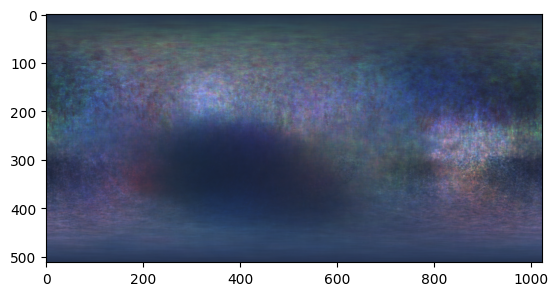

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


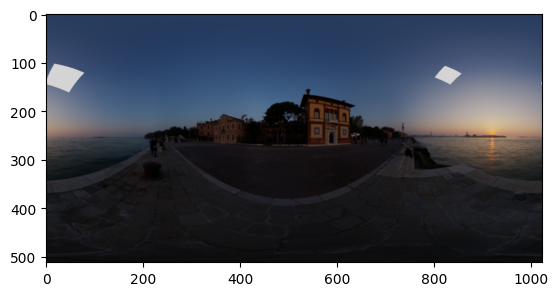

/tmp/ipykernel_24281/586307984.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))


../log/lambda/mic_v1_lambda


/tmp/ipykernel_24281/586307984.py:65: RuntimeWarning: invalid value encountered in power
  imageio.imsave(p / "imgs_test_all" / "envmaps" / "gt_pano.png", (np.clip(flip_bg**(1/2.2), 0, 1)*255).astype(np.uint8))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_ssim': 0.20621717196991626, 'envmap_ssim_top': 0.16719243324750915, 'envmap_lpips_top': 0.6751883029937744, 'envmap_psnr': 14.842373299119034, 'envmap_psnr_top': 13.746358294059702, 'envmap_smape': 77.61170075185655, 'envmap_smape_top': 140.27946216986126}


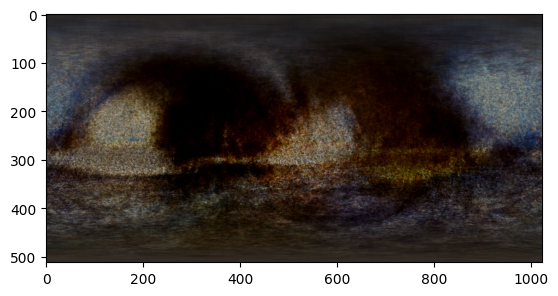

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


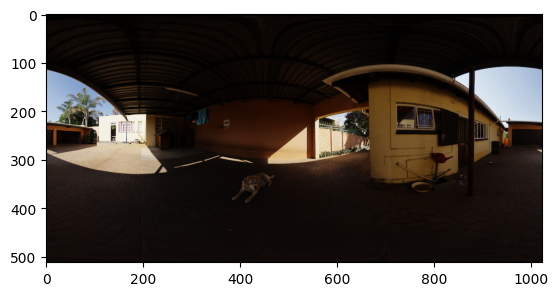

../log/lambda/chair_v1_lambda


/tmp/ipykernel_24281/586307984.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))
/tmp/ipykernel_24281/586307984.py:65: RuntimeWarning: invalid value encountered in power
  imageio.imsave(p / "imgs_test_all" / "envmaps" / "gt_pano.png", (np.clip(flip_bg**(1/2.2), 0, 1)*255).astype(np.uint8))


{'envmap_ssim': 0.3699556038711624, 'envmap_ssim_top': 0.3985405574224909, 'envmap_lpips_top': 0.9105532765388489, 'envmap_psnr': 14.68185544499456, 'envmap_psnr_top': 15.386413518143709, 'envmap_smape': 54.093018180752864, 'envmap_smape_top': 66.62462159891021}


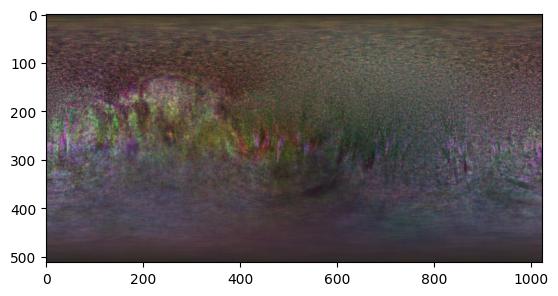

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


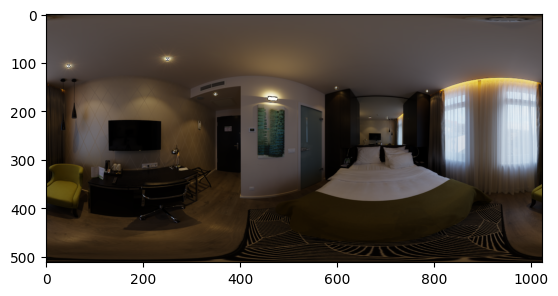

/tmp/ipykernel_24281/586307984.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))


../log/lambda/teapot_v1_lambda
{'envmap_ssim': 0.618664407412416, 'envmap_ssim_top': 0.7328276636734368, 'envmap_lpips_top': 0.4763432741165161, 'envmap_psnr': 15.119103619427198, 'envmap_psnr_top': 19.291503395646128, 'envmap_smape': 44.41473830424755, 'envmap_smape_top': 36.783014816845224}


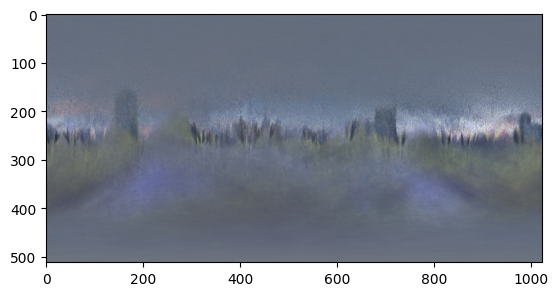

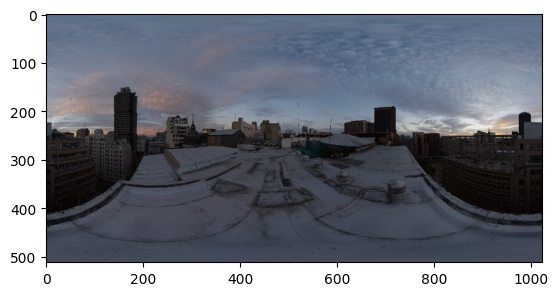

../log/lambda/ball_v1_lambda


/tmp/ipykernel_24281/586307984.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))
/tmp/ipykernel_24281/586307984.py:65: RuntimeWarning: invalid value encountered in power
  imageio.imsave(p / "imgs_test_all" / "envmaps" / "gt_pano.png", (np.clip(flip_bg**(1/2.2), 0, 1)*255).astype(np.uint8))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_ssim': 0.22727857320622527, 'envmap_ssim_top': 0.1353158519921901, 'envmap_lpips_top': 0.8347047567367554, 'envmap_psnr': 16.849242013270914, 'envmap_psnr_top': 15.196184785018255, 'envmap_smape': 57.8331000419836, 'envmap_smape_top': 90.03615870239035}


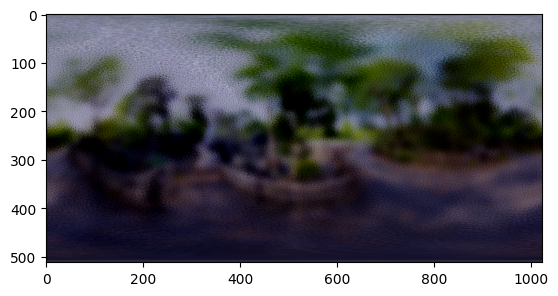

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


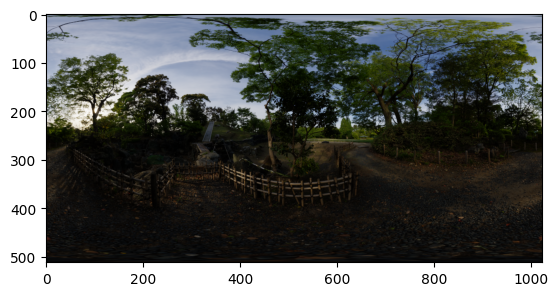

../log/lambda/ficus_v1_lambda


/tmp/ipykernel_24281/586307984.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))
/tmp/ipykernel_24281/586307984.py:65: RuntimeWarning: invalid value encountered in power
  imageio.imsave(p / "imgs_test_all" / "envmaps" / "gt_pano.png", (np.clip(flip_bg**(1/2.2), 0, 1)*255).astype(np.uint8))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_ssim': 0.18230376933358103, 'envmap_ssim_top': 0.23357622503377268, 'envmap_lpips_top': 1.0108087062835693, 'envmap_psnr': 13.800243561157002, 'envmap_psnr_top': 14.575757144353547, 'envmap_smape': 56.97999171377036, 'envmap_smape_top': 73.84384967642258}


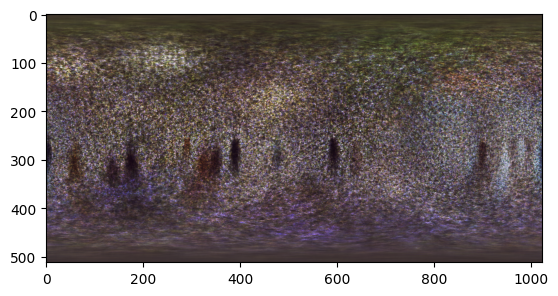

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


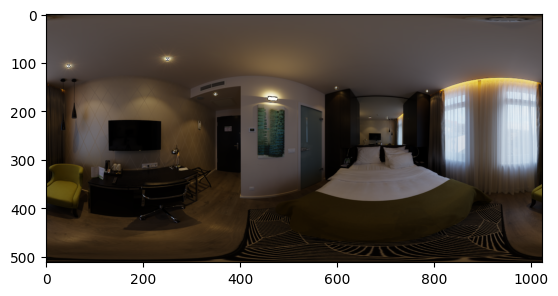

/tmp/ipykernel_24281/586307984.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))


../log/lambda/coffee_v1_lambda


/tmp/ipykernel_24281/586307984.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gt_bg = cv.cvtColor(gt_bg, cv.COLOR_BGR2RGB).astype(np.float)/255


{'envmap_ssim': 0.3993013235424824, 'envmap_ssim_top': 0.3845975149844898, 'envmap_lpips_top': 0.8113799095153809, 'envmap_psnr': 16.548958025741154, 'envmap_psnr_top': 18.652460833359104, 'envmap_smape': 57.20588684408141, 'envmap_smape_top': 71.01704739206474}


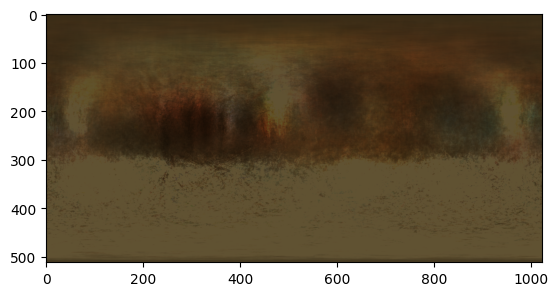

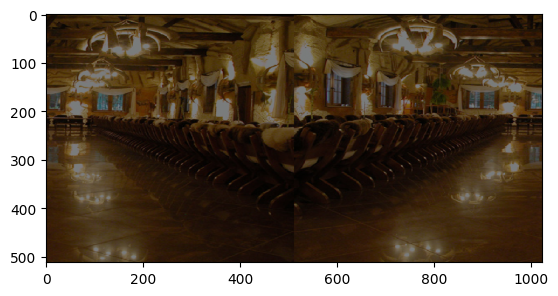

../log/lambda/car_v1_lambda


/tmp/ipykernel_24281/586307984.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))
/tmp/ipykernel_24281/586307984.py:65: RuntimeWarning: invalid value encountered in power
  imageio.imsave(p / "imgs_test_all" / "envmaps" / "gt_pano.png", (np.clip(flip_bg**(1/2.2), 0, 1)*255).astype(np.uint8))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_ssim': 0.19581158360909612, 'envmap_ssim_top': 0.2809643834937299, 'envmap_lpips_top': 0.5148409605026245, 'envmap_psnr': 13.072251438605536, 'envmap_psnr_top': 16.528137966065596, 'envmap_smape': 68.98638852578829, 'envmap_smape_top': 80.77519971706731}


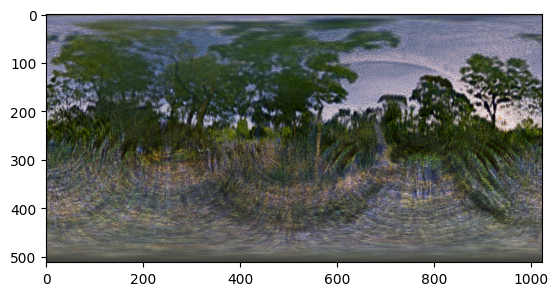

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


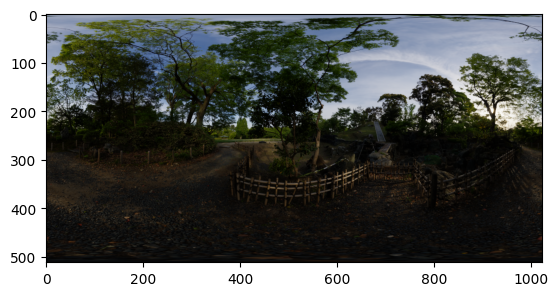

../log/lambda/ship_v1_lambda


/tmp/ipykernel_24281/586307984.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))
/tmp/ipykernel_24281/586307984.py:65: RuntimeWarning: invalid value encountered in power
  imageio.imsave(p / "imgs_test_all" / "envmaps" / "gt_pano.png", (np.clip(flip_bg**(1/2.2), 0, 1)*255).astype(np.uint8))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_ssim': 0.34872104770101975, 'envmap_ssim_top': 0.5818339288552486, 'envmap_lpips_top': 0.604145348072052, 'envmap_psnr': 11.155054825036416, 'envmap_psnr_top': 15.554816238218988, 'envmap_smape': 74.28513651245397, 'envmap_smape_top': 82.88557587895268}


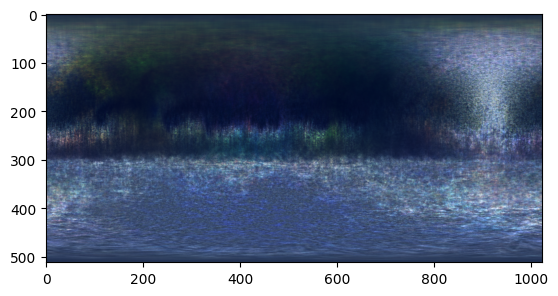

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


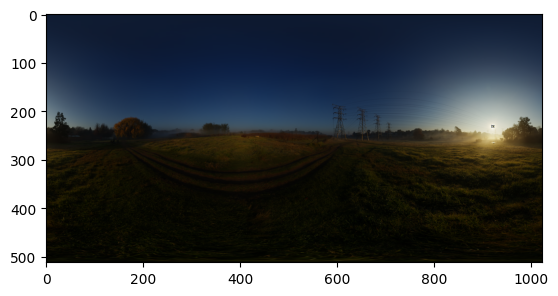

/tmp/ipykernel_24281/586307984.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))


../log/lambda/hotdog_v1_lambda


/tmp/ipykernel_24281/586307984.py:65: RuntimeWarning: invalid value encountered in power
  imageio.imsave(p / "imgs_test_all" / "envmaps" / "gt_pano.png", (np.clip(flip_bg**(1/2.2), 0, 1)*255).astype(np.uint8))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_ssim': 0.3832891809702082, 'envmap_ssim_top': 0.6569349770197448, 'envmap_lpips_top': 0.6016343832015991, 'envmap_psnr': 11.765435603676085, 'envmap_psnr_top': 18.870928891128898, 'envmap_smape': 64.38737276348104, 'envmap_smape_top': 55.6862143091729}


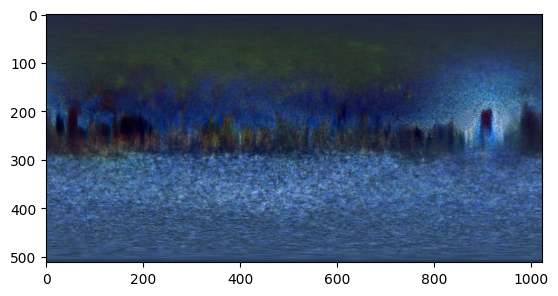

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


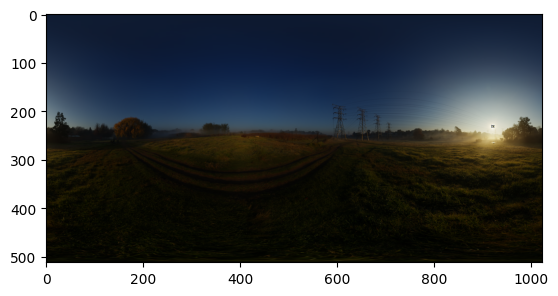

../log/lambda/drums_v1_lambda


/tmp/ipykernel_24281/586307984.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))
/tmp/ipykernel_24281/586307984.py:65: RuntimeWarning: invalid value encountered in power
  imageio.imsave(p / "imgs_test_all" / "envmaps" / "gt_pano.png", (np.clip(flip_bg**(1/2.2), 0, 1)*255).astype(np.uint8))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_ssim': 0.2518021080670191, 'envmap_ssim_top': 0.31109598345438944, 'envmap_lpips_top': 0.8925839066505432, 'envmap_psnr': 15.504772448820638, 'envmap_psnr_top': 17.55521760204536, 'envmap_smape': 50.58589213992942, 'envmap_smape_top': 58.5860419243068}


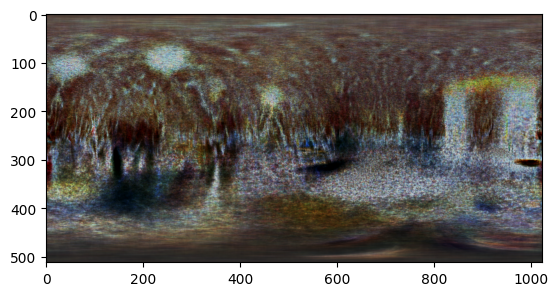

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


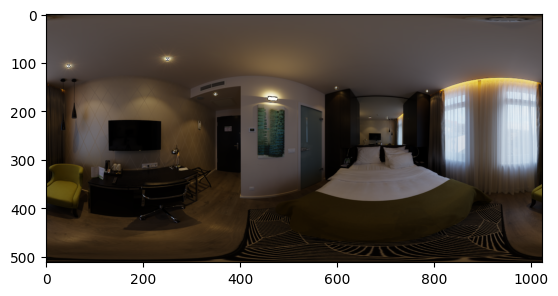

/tmp/ipykernel_24281/586307984.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))


../log/lambda/toaster_v1_lambda


/tmp/ipykernel_24281/586307984.py:65: RuntimeWarning: invalid value encountered in power
  imageio.imsave(p / "imgs_test_all" / "envmaps" / "gt_pano.png", (np.clip(flip_bg**(1/2.2), 0, 1)*255).astype(np.uint8))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_ssim': 0.22063058630374544, 'envmap_ssim_top': 0.2572844516883673, 'envmap_lpips_top': 0.9195579886436462, 'envmap_psnr': 18.11910096894676, 'envmap_psnr_top': 20.055379682923945, 'envmap_smape': 41.42876111738644, 'envmap_smape_top': 50.723587577503714}


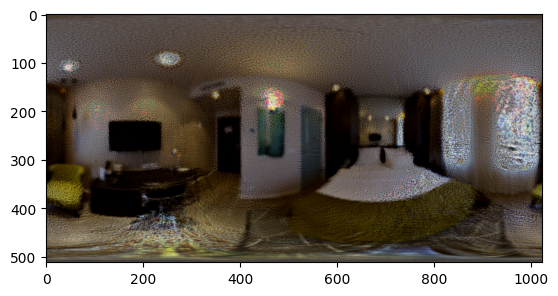

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


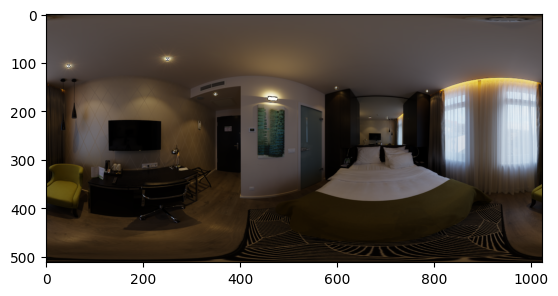

/tmp/ipykernel_24281/586307984.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))


../log/lambda/helmet_v1_lambda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_ssim': 0.4771660812748744, 'envmap_ssim_top': 0.47178791451352353, 'envmap_lpips_top': 0.6466899514198303, 'envmap_psnr': 23.81620084633682, 'envmap_psnr_top': 23.150343331267432, 'envmap_smape': 16.439483269005606, 'envmap_smape_top': 27.60491921338717}


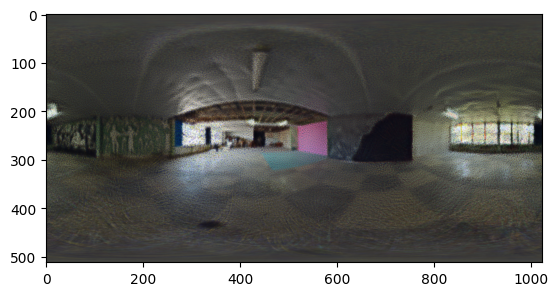

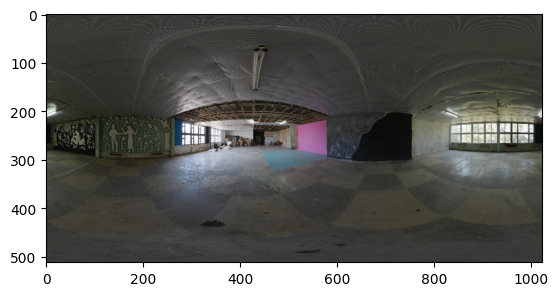

In [4]:
gt_bgs = dict(
    chair='interior.exr',
    ball='forest.exr',
    lego='lego_bg.exr',
    coffee='rj1.jpg',
)
# log_dir = Path("../log") / "fixedmip128"

# log_dir = Path("../log") / "noprednorms_nl0"
# log_dir = Path("../log") / "singlebounce_samen"
# exps = ["noprednorms_nl0_conserve_pb0", 'fixedmip128', 'tensorf', 'singlebounce_samen']
exps = ["lambda"]#, 'fixedmip128', 'tensorf', 'singlebounce_samen']
for exp in exps:
    log_dir = Path("../log") / exp
    for p in log_dir.glob("*"):
        print(p)
        pano_path = p / "imgs_test_all" / "envmaps" / "pano.exr"
        mapped_pano_path = p / "imgs_test_all" / "envmaps" / "mapped_pano.png"
        old_data_path = p / "imgs_test_all" / "stats.yaml"
        new_data_path = p / "imgs_test_all" / "stats_augnle.yaml"
        config = OmegaConf.load(p / 'config.yaml')

        dname = Path(config['dataset']['scenedir']).name
        # if dname != 'car' or exp != 'noprednorms_nl0_conserve_pb0':
        #     continue
        if ('gt_bg' not in config['dataset'] or config['dataset']['gt_bg'] is None) and dname not in gt_bgs.keys():
            continue
        if dname in gt_bgs.keys():
            gt_bg_path = Path("../backgrounds") / gt_bgs[dname]
        else:
            gt_bg_path = Path("../backgrounds") / config['dataset']['gt_bg']

        pred_bg = imageio.imread(str(pano_path))
        if dname == 'coffee':
            pred_bg = pred_bg.clip(min=0, max=1)
            gt_bg = cv.imread(str(gt_bg_path), -1)
            gt_bg = cv.cvtColor(gt_bg, cv.COLOR_BGR2RGB).astype(np.float)/255
        else:
            gt_bg = cv.imread(str(gt_bg_path), -1)
            gt_bg = cv.cvtColor(gt_bg, cv.COLOR_BGR2RGB)
        fH = 512
        fW = 1024
        if dname == 'ball':
            gt_bg = gt_bg[:, ::-1].copy()

            
        resize_bg = F.interpolate(torch.as_tensor(gt_bg).permute(2, 0, 1).unsqueeze(0), (fH, fW)).squeeze(0).permute(1, 2, 0).numpy()
        flip_bg = resize_bg[:, ::-1] # flip
        flip_bg = np.concatenate([flip_bg[:, fW//2:], flip_bg[:, :fW//2]], axis=1)
        pred_bg = F.interpolate(torch.as_tensor(pred_bg).permute(2, 0, 1).unsqueeze(0), (fH, fW)).squeeze(0).permute(1, 2, 0).numpy()

        # def f(x):
        #     return np.log(np.clip(x, 1e-20, 1e20))
        
        # def f_inv(x):
        #     return np.exp(np.clip(x, -20, 20))

        def f(x):
            return x
        
        def f_inv(x):
            return x
        fit_bg, M = fit_bg_color(pred_bg, flip_bg, f, f_inv)
        imageio.imsave(mapped_pano_path, (np.clip(fit_bg**(1/2.2), 0, 1)*255).astype(np.uint8))
        imageio.imsave(p / "imgs_test_all" / "envmaps" / "gt_pano.png", (np.clip(flip_bg**(1/2.2), 0, 1)*255).astype(np.uint8))

        def f(x):
            x = np.clip(x, 0, 99)
            return x / (1+x)
        
        def f_inv(x):
            return -x/(x-1)

        fit_bg, _ = fit_bg_color(fit_bg, flip_bg, f, f_inv, reject_outliers=False)
        # flip_bg = torch.as_tensor(flip_bg).mean(dim=0, keepdims=True).mean(dim=1, keepdims=True).expand(pred_bg.shape).numpy()

        B = 0
        with (p / "imgs_test_all" / "envmaps" / "coeffs.yaml").open('w') as file:
            yaml.dump(dict(M=M.tolist(), B=B), file)

        def scale_fn(x):
            return x / (1+x)

        err = (scale_fn(flip_bg) - scale_fn(fit_bg))**2# * sin_vals * np.pi/2
        # disp_im(err)
        top_psnr = -10 * np.log(np.mean(err[:fH//2])) / np.log(10.0)
        psnr = -10 * np.log(np.mean(err)) / np.log(10.0)

        def smape_fn(x, y, w):
            return (np.abs(x - y) / (np.abs(x) + np.abs(y)).clip(min=1e-8) * 2 * w).mean() * 100
        # disp_im(v.mean(dim=-1))
        sin_vals = np.sin(np.arange(fH) / fH * np.pi).reshape(-1, 1, 1)
        smape = smape_fn((flip_bg), (fit_bg), sin_vals)
        smape_top = smape_fn((flip_bg)[:fH//2], (fit_bg)[:fH//2], sin_vals[:fH//2] * np.pi/2)
        essim = rgb_ssim(scale_fn(flip_bg), scale_fn(fit_bg), 1)
        essim_top = rgb_ssim(scale_fn(flip_bg[:fH//2]), scale_fn(fit_bg[:fH//2]), 1)

        with torch.no_grad():
            gt_bg_t = torch.as_tensor(scale_fn(flip_bg)).float().permute(2, 0, 1).unsqueeze(0).to(device)
            pred_bg_t = torch.as_tensor(scale_fn(fit_bg)).float().permute(2, 0, 1).unsqueeze(0).to(device)
            lpips_top = loss_fn_alex(gt_bg_t[:, :, :fH//2], pred_bg_t[:, :, :fH//2], normalize=True).cpu()

        data = dict(
            envmap_ssim=float(essim),
            envmap_ssim_top=float(essim_top),
            envmap_lpips_top=float(lpips_top),
            envmap_psnr=float(psnr),
            envmap_psnr_top=float(top_psnr),
            envmap_smape=float(smape),
            envmap_smape_top=float(smape_top),
        )
        print(data)


        disp_im(scale_fn(fit_bg))
        disp_im(scale_fn(flip_bg))
        # disp_im((f_inv(fit_bg))**(1/2.2))
        # disp_im((flip_bg)**(1/2.2))
        with old_data_path.open('r') as f:
            old_data = yaml.safe_load(f)
        with new_data_path.open('w') as f:
            yaml.dump(dict(merge_dicts(old_data, data)), f)

In [5]:
print(gt_bgs)

{'chair': 'interior.exr', 'ball': 'forest.exr', 'lego': 'lego_bg.exr', 'coffee': 'rj1.jpg'}
